<a href="https://colab.research.google.com/github/Suhit97/Dog_breed_classification/blob/main/ResNet_%2B_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, time
from PIL import Image
import seaborn as sns
from sklearn import model_selection

from tqdm import tqdm

import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

from keras.utils import to_categorical




In [ ]:
TRAIN_PATH = '/content/gdrive/MyDrive/Dog_Breed_Classification/train'
#TEST_PATH = '../input/dog-breed-identification/test'

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Dog_Breed_Classification/labels.csv")
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Function to plot label distributions
def plot_label_distribution(df_ ):

    fig, ax = plt.subplots(figsize=(25, 6))
    sns.countplot(df_.breed)
    ax.set_title(f'Number of classes : {len(df_.breed.unique())}', fontsize=14)
    ax.set_xlabel('Labels', fontsize=12,)
    ax.set_ylabel('Label Count', fontsize=12)
    #ax.xaxis.set_ticklabels(df_.breed, rotation = 90)
    plt.xticks(rotation=90)
    plt.show()



###But In our case: The classifier should only predict scores for these breeds : beagle, chihuahua, doberman,french_bulldog, golden_retriever, malamute, pug, saint_bernard, scottish_deerhound,tibetan_mastiff

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


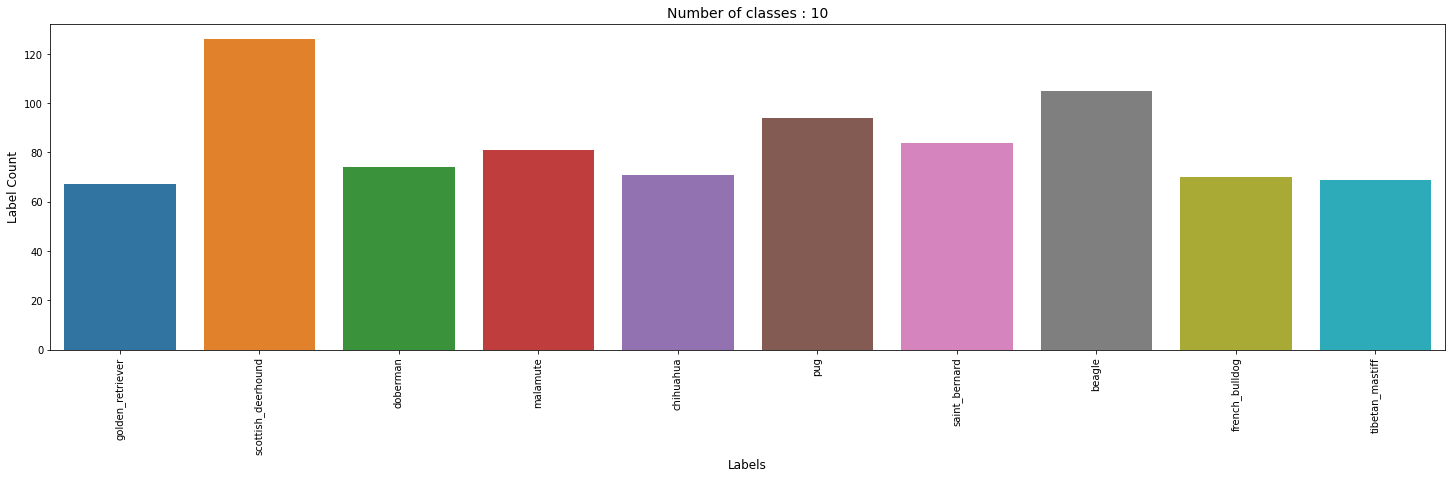

In [ ]:
labels = [ 'beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']

df_new = df[df.breed.isin(labels)]

plot_label_distribution(df_new)

In [ ]:
df_new.breed.value_counts()

scottish_deerhound    126
beagle                105
pug                    94
saint_bernard          84
malamute               81
doberman               74
chihuahua              71
french_bulldog         70
tibetan_mastiff        69
golden_retriever       67
Name: breed, dtype: int64

In [ ]:
# Converting each id to image location path
df_new.id = df_new.id.apply(lambda x: x+'.jpg')
df_new.id = df_new.id.apply(lambda x: TRAIN_PATH+'/'+x)
df_new = df_new.reset_index(drop=True)
df_new.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,id,breed
0,/content/gdrive/MyDrive/Dog_Breed_Classificati...,golden_retriever
1,/content/gdrive/MyDrive/Dog_Breed_Classificati...,scottish_deerhound
2,/content/gdrive/MyDrive/Dog_Breed_Classificati...,doberman
3,/content/gdrive/MyDrive/Dog_Breed_Classificati...,golden_retriever
4,/content/gdrive/MyDrive/Dog_Breed_Classificati...,golden_retriever


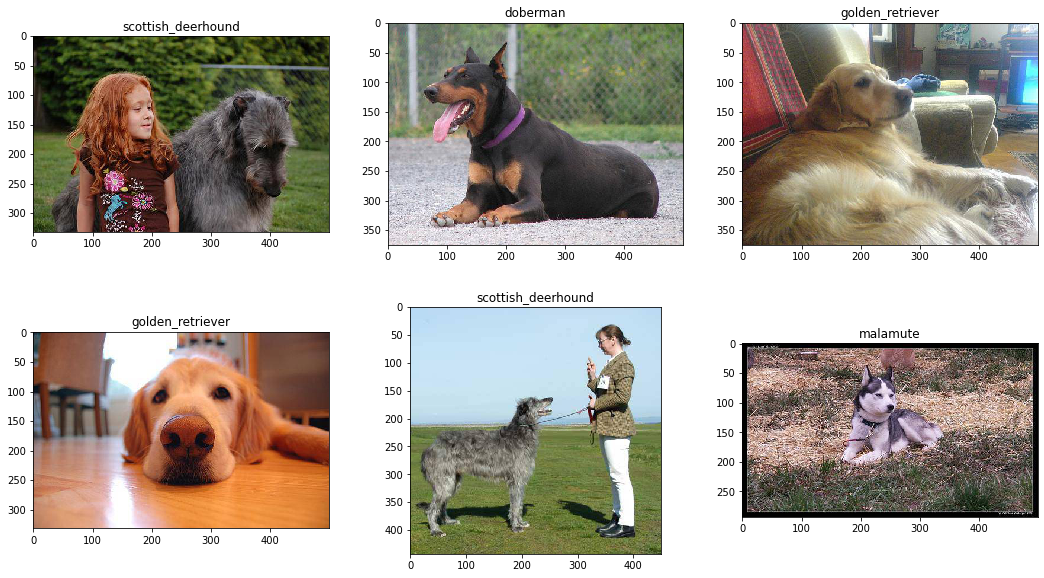

In [ ]:

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 3
rows = 2

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(df_new['breed'].values[i])
    img = plt.imread(df_new.iloc[i]['id'])
    plt.imshow(img, interpolation='nearest')
plt.show()

In [ ]:
n = len(df_new)
breed = set(df_new['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

class_to_num

{'beagle': 7,
 'chihuahua': 8,
 'doberman': 6,
 'french_bulldog': 1,
 'golden_retriever': 9,
 'malamute': 0,
 'pug': 3,
 'saint_bernard': 5,
 'scottish_deerhound': 4,
 'tibetan_mastiff': 2}

In [ ]:
# Label Encoding with class_to_num dictionary
#df_new.breed = df_new.breed.map(class_to_num)
df_new1 = df_new.replace({"breed": class_to_num}) 
df_new1.head()

,id,breed
0,/content/gdrive/MyDrive/Dog_Breed_Classificati...,9
1,/content/gdrive/MyDrive/Dog_Breed_Classificati...,4
2,/content/gdrive/MyDrive/Dog_Breed_Classificati...,6
3,/content/gdrive/MyDrive/Dog_Breed_Classificati...,9
4,/content/gdrive/MyDrive/Dog_Breed_Classificati...,9


In [ ]:
def images_to_array(data_dir, labels_dataframe, img_size = (224,224,3)):
    
    images_names = labels_dataframe['id']
    images_labels = labels_dataframe['breed']
    data_size = len(images_names)
    #initailize output arrays.

    X = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
    y = np.zeros([data_size,1], dtype=np.uint8)
    
    #read data and lables.
    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_dir = os.path.join(image_name)
        img_pixels = load_img(img_dir, target_size=img_size)
        X[i] = img_pixels
        
        image_breed = images_labels[i]
        y[i] = class_to_num[image_breed]
    
    #One hot encoder
    y = to_categorical(y)
    #shuffle    
    indices = np.random.permutation(data_size)
    X = X[indices]
    y = y[indices]
    print('Ouptut Data Size: ', X.shape)
    print('Ouptut Label Size: ', y.shape)
    return X, y

In [ ]:
X, y = images_to_array(TRAIN_PATH, df_new)

100%|██████████| 841/841 [02:42<00:00,  5.19it/s]

Ouptut Data Size:  (841, 224, 224, 3)
Ouptut Label Size:  (841, 10)


In [ ]:
#pickle.dump((X,y), open('/content/gdrive/MyDrive/Dog_Breed_Classification/X_y.pkl', 'wb'))

# Loading the images_to_array from disk
X, y = pickle.load(open('/content/gdrive/MyDrive/Dog_Breed_Classification/X_y.pkl', 'rb'))

In [ ]:
print(X.shape)
print(y.shape)


(841, 224, 224, 3)
(841, 10)


In [ ]:
X_train,X_valid,y_train,y_valid = model_selection.train_test_split(X,y,
                                                                 test_size=0.175,
                                                                 stratify=df_new1.breed
                                                                 )
print(f'Train shape : {X_train.shape}')
print(f'Train label : {y_train.shape}')
print(f'Valid shape : {X_valid.shape}')
print(f'Valid label : {y_valid.shape}')


Train shape : (693, 224, 224, 3)
Train label : (693, 10)
Valid shape : (148, 224, 224, 3)
Valid label : (148, 10)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPool2D
from tensorflow.keras.applications.resnet import ResNet50,preprocess_input

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [ ]:
model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Flatten())
#model.add(BatchNormalization())
#model.add(Dense(2048, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10,kernel_regularizer=l2(0.01), activation='softmax'))

model.layers[0].trainable = False

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
optimizer = Adam()
#optimizer = SGD(lr=1e-3, momentum=0.9)

callbacks = [
    ReduceLROnPlateau(monitor='loss', patience=3, verbose=1),
    EarlyStopping(monitor='loss', patience=5, verbose=1),
    ]


model.compile(optimizer=optimizer,
                loss='hinge',
                metrics=['accuracy'])


In [ ]:
EPOCHS = 16 # Using Hyperparameter Tuning

history = model.fit(X_train, y_train,
                    batch_size=7,
                    epochs=150,
                    verbose=1,
                    validation_data = (X_valid, y_valid),
                    callbacks=callbacks)  

Epoch 1/150
99/99 [==============================] - 39s 45ms/step - loss: 1.2012 - accuracy: 0.0959 - val_loss: 1.0889 - val_accuracy: 0.1284
Epoch 2/150
99/99 [==============================] - 3s 31ms/step - loss: 1.0860 - accuracy: 0.1194 - val_loss: 1.0778 - val_accuracy: 0.1284
Epoch 3/150
99/99 [==============================] - 3s 31ms/step - loss: 1.0811 - accuracy: 0.1084 - val_loss: 1.0757 - val_accuracy: 0.1284
Epoch 4/150
99/99 [==============================] - 3s 31ms/step - loss: 1.0751 - accuracy: 0.1302 - val_loss: 1.0749 - val_accuracy: 0.1284
Epoch 5/150
99/99 [==============================] - 3s 31ms/step - loss: 1.0798 - accuracy: 0.1065 - val_loss: 1.0749 - val_accuracy: 0.1284
Epoch 6/150
99/99 [==============================] - 3s 32ms/step - loss: 1.0718 - accuracy: 0.1437 - val_loss: 1.0746 - val_accuracy: 0.1284
Epoch 7/150
99/99 [==============================] - 3s 31ms/step - loss: 1.0756 - accuracy: 0.1247 - val_loss: 1.0702 - val_accuracy: 0.1554
Epoch

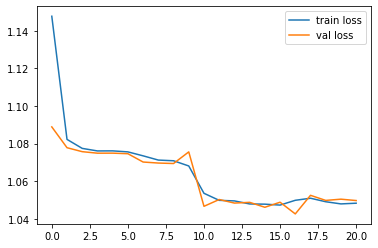

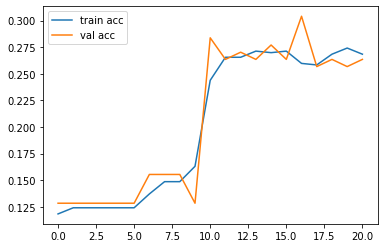

In [ ]:
#Plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')